# Anime Recommendation System Project

## Imported Libraries

#### Common Data Science Libraries

In [22]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#### Surprise Libary (for SVD and KNN models)

In [23]:
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import SVD
from surprise import accuracy
from surprise import Reader
from surprise import Dataset

#### User-Defined Libraries

In [24]:
import finalprojutils

## Data Preprocessing

#### Main Anime Dataset (anime.csv)

In [25]:
anime_df = pd.read_csv("data/anime.csv")


print(anime_df.shape)
print(anime_df.columns.unique())
anime_df.head()

(17562, 35)
Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


#### Anime Ratings Dataset (rating_complete.csv)

In [26]:
ratings_df = pd.read_csv("data/rating_complete.csv")

print(ratings_df.shape)
print(ratings_df.columns.unique())
ratings_df.head()

(57633278, 3)
Index(['user_id', 'anime_id', 'rating'], dtype='object')


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


#### Dataset Cleaning

In [27]:
print("Before:")
print(anime_df.shape)
print(ratings_df.shape)

anime_df.dropna(inplace=True)
ratings_df.dropna(inplace=True)

print("\nAfter:")
print(anime_df.shape)
print(ratings_df.shape)

Before:
(17562, 35)
(57633278, 3)

After:
(17562, 35)
(57633278, 3)


#### CSV for mapping Name to ID used by app.py (id_to_name.csv)

In [28]:
name_to_id_df = anime_df[['MAL_ID', 'Name', 'English name']]
name_to_id_df.to_csv('data/id_to_name.csv', index=False)

#### Dictionaries for Anime ID and Name Mappings

In [29]:
rid_to_name, name_to_rid = finalprojutils.read_item_names()

## Data Exploratory Analysis

In [30]:
anime_ratings_counts = ratings_df['anime_id'].value_counts()
print(f'Number of rated anime: {len(anime_ratings_counts)}')
print(f'Total number of anime: {len(anime_df)}')
print(f'Percentage of rated anime: {(len(anime_ratings_counts) / len(anime_df) * 100):.2f}%')

Number of rated anime: 16872
Total number of anime: 17562
Percentage of rated anime: 96.07%


Rating Counts:


8     14642156
7     13325549
9      9773857
6      6849293
10     6716048
5      3436250
4      1455102
3       696048
2       405556
1       333419
Name: rating, dtype: int64

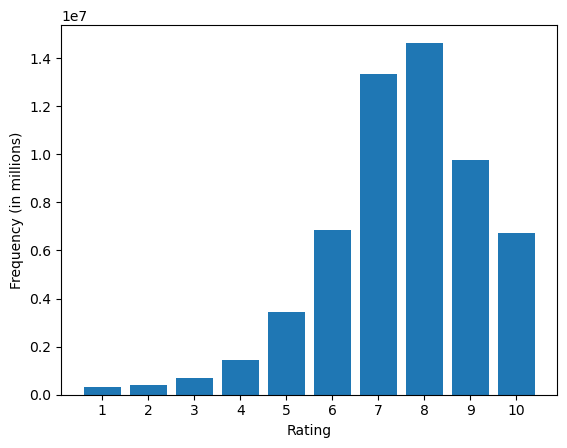

In [31]:
rating_values = ratings_df['rating'].unique()
rating_counts = ratings_df['rating'].value_counts()
plt.bar(rating_counts.index, rating_counts)
plt.xlabel("Rating")
plt.xticks(rating_values)
plt.ylabel("Frequency (in millions)")

print("Rating Counts:")
rating_counts

In [32]:
# returns bounds to be considered outlier for a distribution based on IQR method
def iqr_bounds(value_counts):
    quartiles = np.percentile(value_counts, [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower = quartiles[0] - 1.5 * iqr
    upper = quartiles[2] + 1.5 * iqr
    return lower, upper

# plots both a histogram and boxplot for user ratings per anime and user in a 4x4 grid
# contains an outliers parameter to keep/remove outliers from the distribution
def plot_distributions(df, outliers):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig.tight_layout(pad=5)

    x_labels = ["Ratings Count Per Anime", "Ratings Count Per User"]

    for idx, column in enumerate(['anime_id', 'user_id']):
        value_counts = df[column].value_counts()
        lower, upper = iqr_bounds(value_counts)

        if not outliers:
            value_counts = value_counts[(value_counts >= lower) & (value_counts <= upper)]

        axs[0, idx].hist(value_counts, bins=50, edgecolor = "black")
        axs[0, idx].set_xlabel(x_labels[idx])
        axs[0, idx].set_ylabel("Frequency")

        axs[1, idx].boxplot(value_counts, vert=False)
        axs[1, idx].set_xlabel(x_labels[idx])
        axs[1, idx].set_yticks([])

#### Ratings Distributions with Outliers

In [33]:
population_counts_stats = pd.concat([ratings_df['anime_id'].value_counts().describe(),
                                     ratings_df['user_id'].value_counts().describe()],
                                     axis=1)
population_counts_stats.columns = ['Rating Count/Anime', 'Rating Count/User']
population_counts_stats

,Rating Count/Anime,Rating Count/User
count,16872.000000,310059.000000
mean,3415.912636,185.878423
std,10304.206874,255.290522
min,1.000000,1.000000
25%,40.000000,43.000000
50%,266.000000,113.000000
75%,1671.250000,238.000000
max,182375.000000,15455.000000


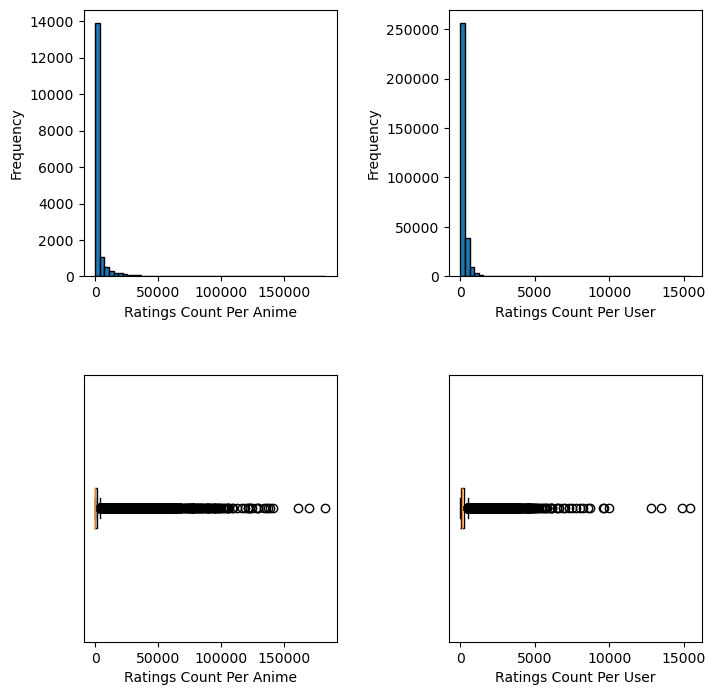

In [35]:
plot_distributions(ratings_df, outliers=True)

#### Ratings Distributions without Outliers

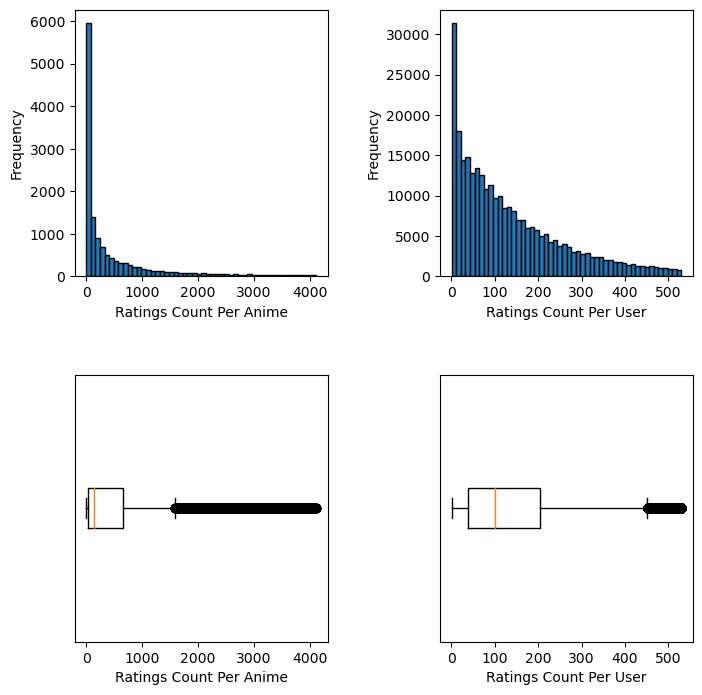

In [34]:
plot_distributions(ratings_df, outliers=False)

#### Ratings Random Sample

In [36]:
# From a dataframe sample all the ratings from N random users, using 'User ID'
def sample_n_user_ratings(source_df, n):
    users = source_df['user_id'].unique()
    user_id_set = set(np.random.choice(users, size=n, replace=False))

    result_df = source_df[source_df['user_id'].isin(user_id_set)].copy()
    
    return result_df

ratings_sample = sample_n_user_ratings(ratings_df, 2000)

In [37]:
sample_counts_stats = pd.concat([ratings_sample['anime_id'].value_counts().describe(),
                                 ratings_sample['user_id'].value_counts().describe()],
                                 axis=1)
sample_counts_stats.columns = ['Rating Count/Anime', 'Rating Count/User']
sample_counts_stats

,Rating Count/Anime,Rating Count/User
count,9396.000000,2000.000000
mean,39.295871,184.612000
std,86.005042,233.154457
min,1.000000,1.000000
25%,2.000000,43.000000
50%,8.000000,114.000000
75%,35.000000,243.000000
max,1171.000000,2749.000000


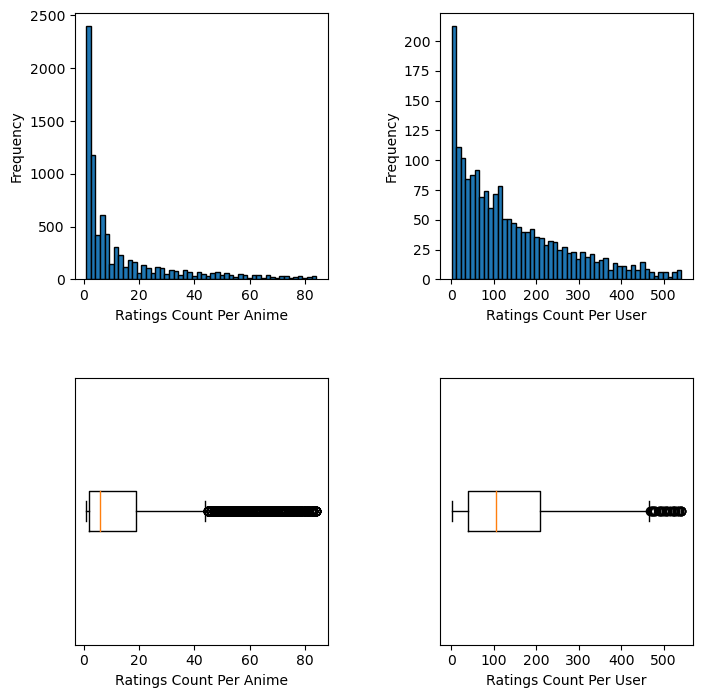

In [38]:
plot_distributions(ratings_sample, outliers=False)

unique anime rated over number of users sampled

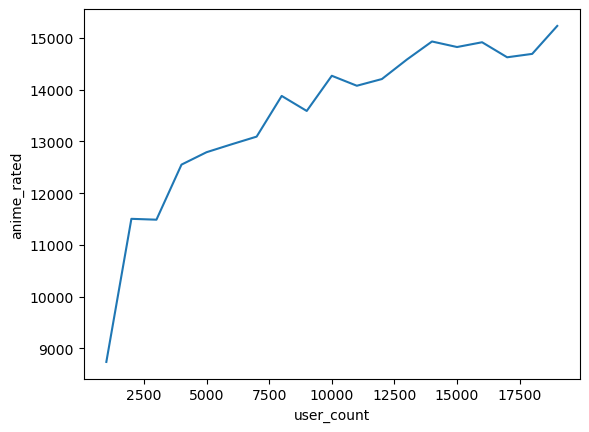

In [39]:
unique_anime_rated = pd.DataFrame(columns = ['user_count', 'anime_rated'])

for i in range(1000, 20000, 1000):
    count = 0
    for j in range(1,6):
        plot_sample = sample_n_user_ratings(ratings_df, i)
        animeRated = len(plot_sample['anime_id'].unique())
        count += animeRated
    count /= 5

    unique_anime_rated.loc[len(unique_anime_rated)] = [i, count]
    
sns.lineplot(x='user_count', y='anime_rated', data=unique_anime_rated, markers='o')
plt.show()

#### Ratings Sample CSV File (frontend_ratings_sample.csv)

In [40]:
# Save as file for frontend usage
ratings_sample.to_csv('data/frontend_ratings_sample.csv', index=False)

## Singular Value Decomposition (SVD)

Data Setup

In [41]:
svd_ratings_dataset = finalprojutils.create_dataset_from_df(ratings_sample)

Grid Search

In [42]:
# Grid search for optimal hyperparameters
param_grid = {
    'lr_all' : [.01],
    'n_factors' : [10, 25, 50, 75, 100],
    'reg_all': [.1],
    'n_epochs' : [25, 50, 100]
}
gridsearch_svd = GridSearchCV(
    SVD, 
    param_grid = param_grid, 
    n_jobs = -1, 
    joblib_verbose = 3)

gridsearch_svd.fit(svd_ratings_dataset)

print(gridsearch_svd.best_score)
print(gridsearch_svd.best_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   32.7s


{'rmse': 1.2018595760747481, 'mae': 0.8994370260442514}
{'rmse': {'lr_all': 0.01, 'n_factors': 100, 'reg_all': 0.1, 'n_epochs': 25}, 'mae': {'lr_all': 0.01, 'n_factors': 100, 'reg_all': 0.1, 'n_epochs': 50}}


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  3.1min finished


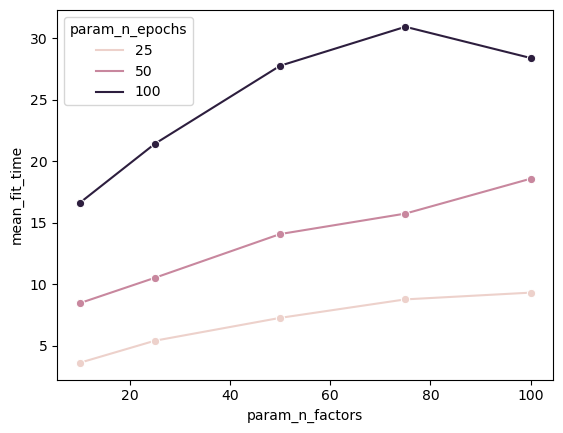

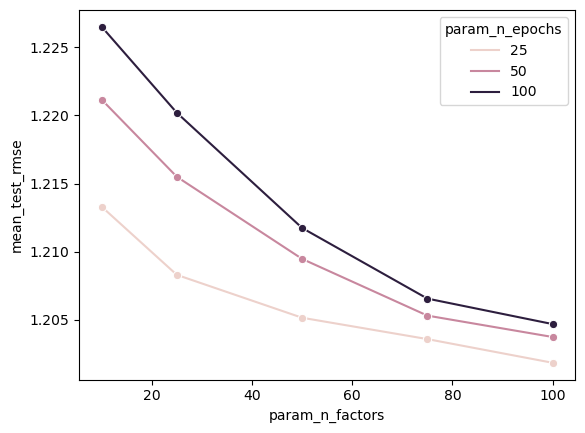

In [43]:
gs_results_df = pd.DataFrame.from_dict(gridsearch_svd.cv_results)

# Write results to file
gs_results_df.to_csv('data/svd_gridsearch_results.csv', index=False)

# Train time for different n factors (embedding size)
sns.lineplot(x='param_n_factors', y='mean_fit_time', hue='param_n_epochs', data=gs_results_df, marker='o')
plt.show()

# RMSE for different n factors
sns.lineplot(x='param_n_factors', y='mean_test_rmse', hue='param_n_epochs', data=gs_results_df, marker='o')
plt.show()

In [44]:
# Create model instance from grid search optimal hyperparameters
svd_instance = gridsearch_svd.best_estimator["rmse"]
# Print Params
print(svd_instance.__dict__)

{'n_factors': 100, 'n_epochs': 25, 'biased': True, 'init_mean': 0, 'init_std_dev': 0.1, 'lr_bu': 0.01, 'lr_bi': 0.01, 'lr_pu': 0.01, 'lr_qi': 0.01, 'reg_bu': 0.1, 'reg_bi': 0.1, 'reg_pu': 0.1, 'reg_qi': 0.1, 'random_state': None, 'verbose': False, 'bsl_options': {}, 'sim_options': {'user_based': True}}


#### Recommendations with SVD Model

In [45]:
# Create predictions for a mew user provided their anime ratings
# This refits the entire model with the new user appended onto the base df with a user ID of -1

def create_predictions_for_user(model_instance, base_train_df, anime_ids, ratings):

    # Create suprise dataset with new user
    predict_dataset = finalprojutils.create_predict_dataset(
        base_train_df, 
        anime_ids,
        ratings)

    # Retrain
    model_instance.fit(predict_dataset.build_full_trainset())

    # Generate predictions
    print("Generating Anime IDs")
    predict_anime_ids = list(rid_to_name)

    # Remove user provided ids from being predicted
    predict_anime_ids = [int(id) for id in predict_anime_ids if int(id) not in anime_ids]
    predict_anime_ids = pd.unique(predict_anime_ids)

    print("Getting Predictions")
    # Generate and return predictions for all the anime
    return finalprojutils.get_predictions(model_instance, -1, predict_anime_ids)

def create_predictions_for_new_user(model_instance, base_train_df, anime_ids, ratings, print_top_25 = True):
# No randomness between each fit
    model_instance.random_state = 1

    user_1_predictions = create_predictions_for_user(
        model_instance,
        base_train_df,
        anime_ids,
        ratings
        )

    # Print predictions
    if print_top_25:
        print(finalprojutils.get_top_n_string(user_1_predictions, 25, rid_to_name))

In [46]:
# User 1 
# Drama / romance
user_1_anime_ids = [4224, 23273, 1723, 32281, 37450, 2167, 121]
user_1_ratings = [10, 8, 9, 9, 10, 9, 4]

create_predictions_for_new_user(svd_instance, ratings_sample, user_1_anime_ids, user_1_ratings)

Generating Anime IDs
Getting Predictions
Top 25 predicted scores
1. Fate/stay night Movie: Heaven's Feel - III. Spring Song (33050) - 9.3014
2. Uchuu Senkan Yamato 2199 (12029) - 9.2898
3. Mo Dao Zu Shi (37208) - 9.0789
4. Katanagatari (6594) - 9.0022
5. Shouwa Genroku Rakugo Shinjuu: Sukeroku Futatabi-hen (33095) - 8.992
6. Ginga Eiyuu Densetsu (820) - 8.9897
7. Kizumonogatari III: Reiketsu-hen (31758) - 8.9616
8. Clannad: After Story (4181) - 8.9616
9. Made in Abyss (34599) - 8.9544
10. Gintama' (9969) - 8.9537
11. Koe no Katachi (28851) - 8.9506
12. Gintama: Yorinuki Gintama-san on Theater 2D (21899) - 8.9334
13. Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou (32935) - 8.9188
14. GintamaÂ° (28977) - 8.918
15. 3-gatsu no Lion 2nd Season (35180) - 8.9132
16. Gintama (918) - 8.9087
17. Cross Game (5941) - 8.9007
18. Steins;Gate (9253) - 8.8996
19. Monogatari Series: Second Season (17074) - 8.8765
20. Suzumiya Haruhi no Shoushitsu (7311) - 8.8751
21. Black Jack (1520) - 8.86

In [47]:
# User 2 
# Action / Adventure
user_2_anime_ids = [114, 31964, 32051, 34134, 38000]
user_2_ratings = [9, 10, 8, 9, 9]

create_predictions_for_new_user(svd_instance, ratings_sample, user_2_anime_ids, user_2_ratings)

Generating Anime IDs
Getting Predictions
Top 25 predicted scores
1. Fate/stay night Movie: Heaven's Feel - III. Spring Song (33050) - 9.8713
2. Ginga Eiyuu Densetsu (820) - 9.7562
3. Gintama' (9969) - 9.6792
4. Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou (32935) - 9.6413
5. Gintama (918) - 9.626
6. Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare (15335) - 9.6244
7. Gintama.: Shirogane no Tamashii-hen - Kouhan-sen (37491) - 9.5733
8. Made in Abyss (34599) - 9.5683
9. Monster (19) - 9.566
10. Gintama': Enchousen (15417) - 9.5636
11. 3-gatsu no Lion 2nd Season (35180) - 9.5626
12. GintamaÂ° (28977) - 9.5592
13. Kimi no Na wa. (32281) - 9.5509
14. Kimetsu no Yaiba Movie: Mugen Ressha-hen (40456) - 9.5183
15. Steins;Gate (9253) - 9.5037
16. Fullmetal Alchemist: Brotherhood (5114) - 9.5002
17. Mo Dao Zu Shi (37208) - 9.4954
18. Gintama: Yorinuki Gintama-san on Theater 2D (21899) - 9.4756
19. Hunter x Hunter (2011) (11061) - 9.4469
20. Uchuu Senkan Yamato 2199 (12029) - 9

In [48]:
# User 3 
# Boys Love
user_3_anime_ids = [114, 31964, 32051, 34134, 38000, 39533, 30346, 44055, 918]
user_3_ratings = [4, 5, 4, 6, 4, 10, 10, 9, 4]

create_predictions_for_new_user(svd_instance, ratings_sample, user_3_anime_ids, user_3_ratings)

Generating Anime IDs
Getting Predictions
Top 25 predicted scores
1. Uchuu Senkan Yamato 2199 (12029) - 8.3974
2. Gintama: Yorinuki Gintama-san on Theater 2D (21899) - 8.0058
3. Petshop of Horrors (326) - 8.0038
4. Fate/stay night Movie: Heaven's Feel - III. Spring Song (33050) - 7.9153
5. Mahou Shoujo MadokaâMagica Movie 3: Hangyaku no Monogatari (11981) - 7.5783
6. Stranger: Mukou Hadan Pilot (14617) - 7.5703
7. Gintama': Futon ni Haitte kara Buki Nokoshi ni Kizuite Neru ni Nerenai Toki mo Aru (25313) - 7.5634
8. Aria the Origination: Sono Choppiri Himitsu no Basho ni... (4772) - 7.5361
9. Detective Conan Movie 20: The Darkest Nightmare (32005) - 7.4945
10. Ginga Eiyuu Densetsu: Arata Naru Tatakai no Overture (3016) - 7.4655
11. Houseki no Kuni (TV) (35557) - 7.4574
12. Kara no Kyoukai 7: Satsujin Kousatsu (Go) (5205) - 7.4322
13. Mobile Suit Gundam 0080: War in the Pocket (82) - 7.4308
14. Ginga Eiyuu Densetsu (820) - 7.4259
15. Mobile Suit Gundam: The Origin (10937) - 7.418
16. Ka

#### Training/Predict Time With Scaling User Count

Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions
Generating Anime IDs
Getting Predictions


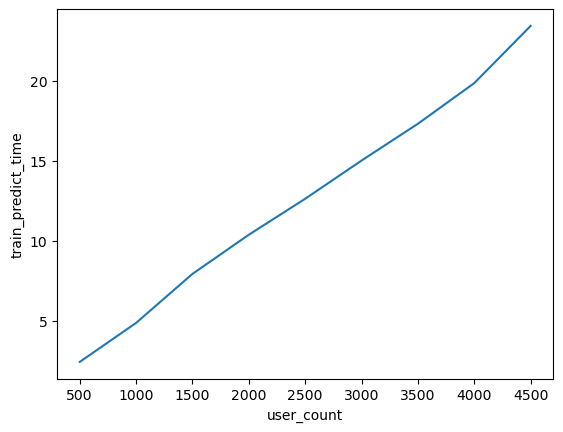

In [49]:
import time
user_1_anime_ids = [4224, 23273, 1723, 32281, 37450, 2167, 121]
user_1_ratings = [10, 8, 9, 9, 10, 9, 4]

def plot_training_times(low, high, step, model_instance, anime_ids, ratings):
    train_times = pd.DataFrame(columns = ['user_count', 'train_predict_time'])

    for i in range(low, high, step):
        test_ratings_sample = sample_n_user_ratings(ratings_df, i)
        start = time.time()
        create_predictions_for_new_user(model_instance, test_ratings_sample, anime_ids, ratings, False)
        end = time.time()
        elapsed = end - start
        train_times.loc[len(train_times)] = [i, elapsed]
        # print(f'sample of {i} users took {elapsed} seconds to train and predict a new user')

    sns.lineplot(x='user_count', y='train_predict_time', data=train_times, markers='o')
    plt.show()

test_instance = SVD(lr_all = 0.01, n_factors = 100, reg_all = 0.1, n_epochs = 50)
plot_training_times(500, 5000, 500, test_instance, user_1_anime_ids, user_1_ratings)

## K-Nearest Neighbors (KNN)

#### Loading Sample into Dataset

In [50]:
reader = Reader(rating_scale=(1,10))
knn_data = Dataset.load_from_df(ratings_sample, reader)
knn_data

#### KNN Basic

In [51]:
knn_basic_algo = KNNBasic(k=10, sim_options={'name': 'cosine', 'user_based': 'False'})

cv_knn_basic = cross_validate(knn_basic_algo, knn_data, measures=['rmse', 'mae'], cv=5, verbose=True)
cv_knn_basic

avg_rmse_basic = np.mean(cv_knn_basic['test_rmse'])
avg_mae_basic = np.mean(cv_knn_basic['test_mae'])
print("\nAverage RMSE:", round(avg_rmse_basic, 4))
print("Average MAE:", round(avg_mae_basic, 4))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5757  1.5805  1.5843  1.5718  1.5752  1.5775  0.0044  
MAE (testset)     1.1878  1.1952  1.1969  1.1884  1.1890  1.1915  0.0038  
Fit time          4.94    5.96    5.38    5.39    5.38    5.41    0.32    
Test time         11.86   11.62   11.78   11.62   12.21   11.82   0.22    

Average RMSE: 1.5775
Average MAE: 1.1915


#### KNN Baseline

In [52]:
knn_baseline_algo = KNNBaseline(k=10, sim_options={'name': 'cosine', 'user_based': 'False'})

cv_knn_baseline = cross_validate(knn_baseline_algo, knn_data, measures=['rmse', 'mae'], cv=5, verbose=True)
cv_knn_baseline

avg_rmse_baseline = np.mean(cv_knn_baseline['test_rmse'])
avg_mae_baseline = np.mean(cv_knn_baseline['test_mae'])
print("\nAverage RMSE:", round(avg_rmse_baseline, 4))
print("Average MAE:", round(avg_mae_baseline, 4))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2738  1.2588  1.2581  1.2657  1.2585  1.2630  0.0061  
MAE (testset)     0.9565  0.9448  0.9473  0.9492  0.9461  0.9488  0.0041  
Fit time          5.94    6.31    6.46    6.84    6.64    6.44    0.31    
Test time         12.31   12.05   12.84   12.37   13.58   12.63   0.54    

Average RMSE: 1.263
Average

#### KNN With Means

In [53]:
knn_means_algo = KNNWithMeans(k=10, sim_options={'name': 'cosine', 'user_based': 'False'})

cv_knn_means = cross_validate(knn_means_algo, knn_data, measures=['rmse', 'mae'], cv=5, verbose=True)
cv_knn_means

avg_rmse_means = np.mean(cv_knn_means['test_rmse'])
avg_mae_means = np.mean(cv_knn_means['test_mae'])
print("\nAverage RMSE:", round(avg_rmse_means, 4))
print("Average MAE:", round(avg_mae_means, 4))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3018  1.3083  1.3126  1.3111  1.3105  1.3089  0.0038  
MAE (testset)     0.9849  0.9911  0.9926  0.9904  0.9926  0.9903  0.0028  
Fit time          5.03    5.49    5.56    5.73    5.50    5.46    0.23    
Test time         12.41   11.98   11.78   12.23   11.84   12.05   0.24    

Average RMSE: 1.3089
Average MAE: 0.9903


#### Best KNN Model

In [55]:
best_knn_algo = None
best_knn_rmse = np.min([avg_rmse_basic, avg_rmse_baseline, avg_rmse_means])
best_knn_mae = np.min([avg_mae_basic, avg_mae_baseline, avg_mae_means])
best_algo_type = ""

if best_knn_rmse == avg_rmse_basic:
    best_algo_type = "KNN Basic"
    best_knn_algo = knn_basic_algo
elif best_knn_rmse == avg_rmse_baseline:
    best_algo_type = "KNN Baseline"
    best_knn_algo = knn_baseline_algo
else:
    best_algo_type = "KNN With Means"
    best_knn_algo = knn_means_algo

print("Best KNN Algorithm:", best_algo_type)
print("Best Average RMSE:", round(best_knn_rmse, 4))
print("Best Average MAE:", round(best_knn_mae, 4))

knn_rmses_df = pd.DataFrame({'KNN Basic': [avg_rmse_basic, avg_mae_basic],
                             'KNN Baseline': [avg_rmse_baseline, avg_mae_baseline],
                             'KNN With Means': [avg_rmse_means, avg_mae_means]})
knn_rmses_df.index = ['Average RMSE', 'Average MAE']
knn_rmses_df

Best KNN Algorithm: KNN Baseline
Best Average RMSE: 1.263
Best Average MAE: 0.9488


,KNN Basic,KNN Baseline,KNN With Means
Average RMSE,1.577511,1.262999,1.308868
Average MAE,1.191456,0.948801,0.990314


#### Recommendations with KNN

In [56]:
# model input is a single anime, output is k nearest animes
anime_name = "Cowboy Bebop"

# anime name must be mapped to id for model
anime_raw_id = int(name_to_rid[anime_name.lower()])
anime_inner_id = best_knn_algo.trainset.to_inner_iid(anime_raw_id)

anime_neighbors = best_knn_algo.get_neighbors(anime_inner_id, k=10)

# print recommendations
print("The 10 nearest neighbors of", anime_name, "are:")
for inner_id in anime_neighbors:
    print(rid_to_name[str(best_knn_algo.trainset.to_raw_iid(inner_id))])

The 10 nearest neighbors of Cowboy Bebop are:
Somali to Mori no Kamisama
Kiznaiver
One Punch Man
Ergo Proxy
Hundred
Sword Art Online Alternative: Gun Gale Online
Kyokou Suiri
Harukanaru Toki no Naka de 3: Kurenai no Tsuki
Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season
Fruits Basket


## Exported Models for Front-end

In [35]:
import pickle

pickle.dump(best_knn_algo, open('knn_model.pkl','wb'))
pickle.dump(svd_instance, open('svd_model.pkl','wb'))